In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
#Tensorflow libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import os
from datetime import datetime

In [2]:
# Function to create the folder path dynamically
def get_training_folder(base_dir='datasets'):
    current_date = datetime.now().strftime("%Y_%m_%d")
    folder_name = f"train_{current_date}"
    training_folder = os.path.join(base_dir, folder_name)
    return training_folder

# Define the base directory where all datasets are located
base_dir = 'datasets'

# Get the training folder for the current date
training_folder = get_training_folder(base_dir)
print(f"Training folder for today: {training_folder}")

dir_names = ['ba', 'ca', 'da', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'wa', 'ya']

# Ensure the training folder exists (for demonstration purposes, we'll just print it)
if not os.path.exists(training_folder):
    os.makedirs(training_folder)
    for name in dir_names:
        path = os.path.join(training_folder, name)
        os.makedirs(path, exist_ok=True)
    print(f"Created training folder: {training_folder}")

# Get a list of all directories within the base directory matching the format train_YYYY_MM_DD
dataset_dirs = [dir for dir in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, dir)) and dir.startswith('train_')]

# Combine the base directory with each dataset directory to get the full path
data_dirs = [os.path.join(base_dir, dir) for dir in dataset_dirs]

# Convert directories to pathlib.Path objects
data_dirs = [pathlib.Path(data_dir) for data_dir in data_dirs]

data_dirs

Training folder for today: datasets/train_2024_05_23


[PosixPath('datasets/train_2024_05_23'),
 PosixPath('datasets/train_2024_05_22')]

In [5]:
def load_dataset_from_dirs(dirs, validation_split=0.2, subset="training", seed=123, image_size=(180, 180), batch_size=10):
    datasets = []
    for dir in dirs:
        try:
            ds = tf.keras.utils.image_dataset_from_directory(
                dir,
                validation_split=validation_split,
                subset=subset,
                seed=seed,
                image_size=image_size,
                batch_size=batch_size
            )
            if ds.cardinality().numpy() > 0:  # Ensure the dataset is not empty
                datasets.append(ds)
            else:
                print(f"No images found for subset '{subset}' in directory: {dir}")
        except ValueError as e:
            print(f"Skipping directory '{dir}' due to error: {e}")
    
    if not datasets:
        raise ValueError(f"No valid datasets found for subset '{subset}'. Ensure that directories contain class subfolders with images.")
    
    # Concatenate all datasets
    combined_ds = datasets[0]
    for ds in datasets[1:]:
        combined_ds = combined_ds.concatenate(ds)
    
    return combined_ds

# Split dataset for training
train_ds = load_dataset_from_dirs(data_dirs, validation_split=0.2, subset="training")
# Split dataset for validation
val_ds = load_dataset_from_dirs(data_dirs, validation_split=0.2, subset="validation")

Found 1 files belonging to 18 classes.
Using 1 files for training.
Skipping directory 'datasets/train_2024_05_23' due to error: No images found in directory datasets/train_2024_05_23. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')
Found 3781 files belonging to 18 classes.
Using 3025 files for training.
Found 1 files belonging to 18 classes.
Using 0 files for validation.
Found 3781 files belonging to 18 classes.
Using 756 files for validation.


In [6]:
# Batch size
batch_size = 10
# image height
img_height = 180
# image width
img_width = 180

In [7]:
# Get class names
class_names = train_ds.class_names
print(class_names)

['ba', 'ca', 'da', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'wa', 'ya']


2024-05-23 03:08:26.533839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(10, 180, 180, 3)
(10,)


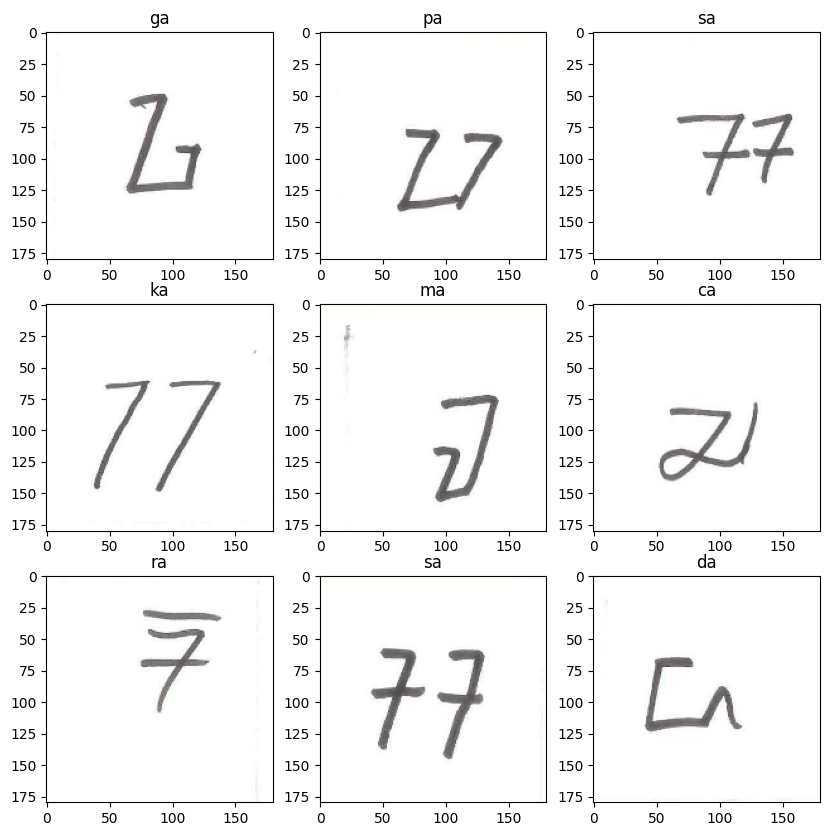

In [8]:
# Visualize some training images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("on")

# Print shape of image batches
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [9]:
#Create autotune object
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Create a normalization layer
normalization_layer = layers.Rescaling(1./255)

In [11]:
#normalize dataser using with norm. layer
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# sparete as image and label
image_batch, labels_batch = next(iter(normalized_ds))
# check the first image max and min value
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print("minumum value:",np.min(first_image), "maximum values: ",np.max(first_image))

minumum value: 0.2830823 maximum values:  1.0


In [13]:
# Get class names
num_classes = len(class_names)

# Build model layers
model = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,962 (15.22 MB)

 Trainable params: 3,990,962 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model for 10 epochs with Keras
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.1126 - loss: 2.8522 - val_accuracy: 0.4729 - val_loss: 1.8285
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.5567 - loss: 1.4164 - val_accuracy: 0.7649 - val_loss: 0.7831
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 39s 130ms/step - accuracy: 0.9008 - loss: 0.3276 - val_accuracy: 0.8349 - val_loss: 0.5644
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9693 - loss: 0.0925 - val_accuracy: 0.8785 - val_loss: 0.4211
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - accuracy: 0.9915 - loss: 0.0368 - val_accuracy: 0.8877 - val_loss: 0.4819
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9940 - loss: 0.0188 - val_accuracy: 0.8877 - val_loss: 0.4146
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 37s 121ms/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 0.9009 - val_loss: 0.4235
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 1.0000 - loss: 4

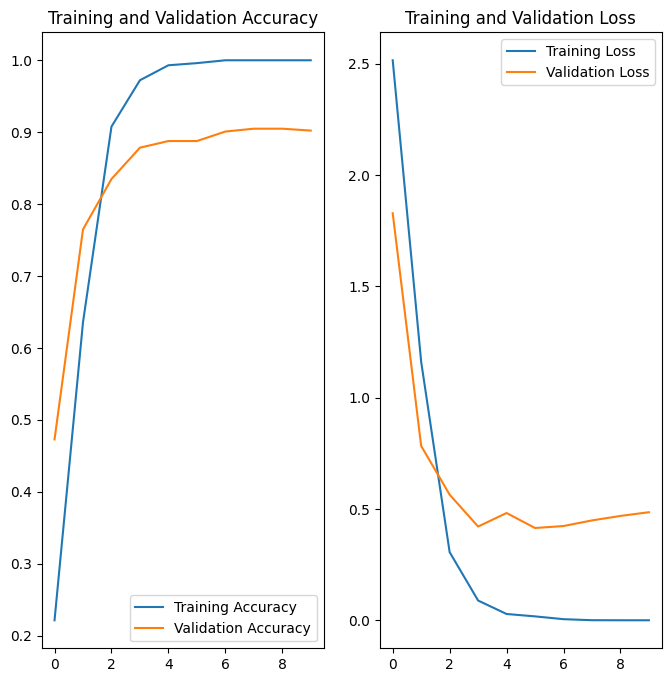

In [16]:
# Get training accuracy from history
acc = history.history['accuracy']
# Get validation accuracy
val_acc = history.history['val_accuracy']
# Get training loss
loss = history.history['loss']
# Get validation loss
val_loss = history.history['val_loss']

epochs_range = range(epochs)
# Plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# create augmentation sequentions
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2024-05-23 03:16:11.227883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


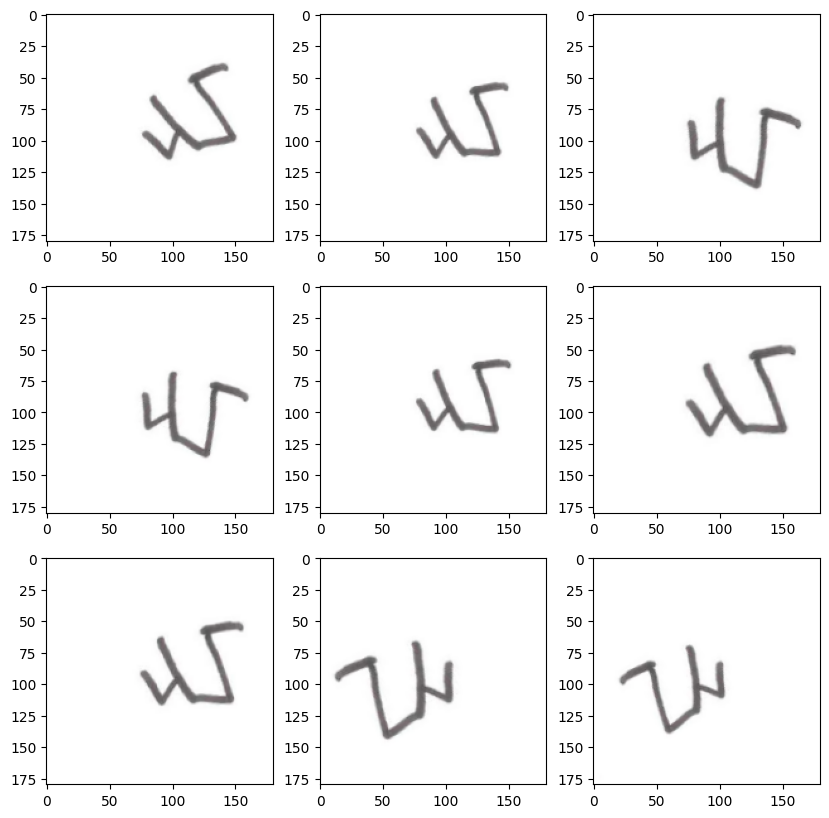

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("on")

In [19]:
# Create neural network with tf.keras.layers.Dropout before training it using the augmented images
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step - accuracy: 0.0568 - loss: 2.9311 - val_accuracy: 0.0449 - val_loss: 2.8911
Epoch 2/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 39s 130ms/step - accuracy: 0.0512 - loss: 2.8904 - val_accuracy: 0.0449 - val_loss: 2.8919
Epoch 3/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.0538 - loss: 2.8903 - val_accuracy: 0.0449 - val_loss: 2.8926
Epoch 4/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - accuracy: 0.0497 - loss: 2.8906 - val_accuracy: 0.0462 - val_loss: 2.8936
Epoch 5/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 42s 140ms/step - accuracy: 0.0557 - loss: 2.8902 - val_accuracy: 0.0449 - val_loss: 2.8936
Epoch 6/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.0650 - loss: 2.8899 - val_accuracy: 0.0449 - val_loss: 2.8940
Epoch 7/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - accuracy: 0.0556 - loss: 2.8906 - val_accuracy: 0.0449 - val_loss: 2.8940
Epoch 8/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 39s 128ms/step - accuracy: 0.0558 - loss: 2

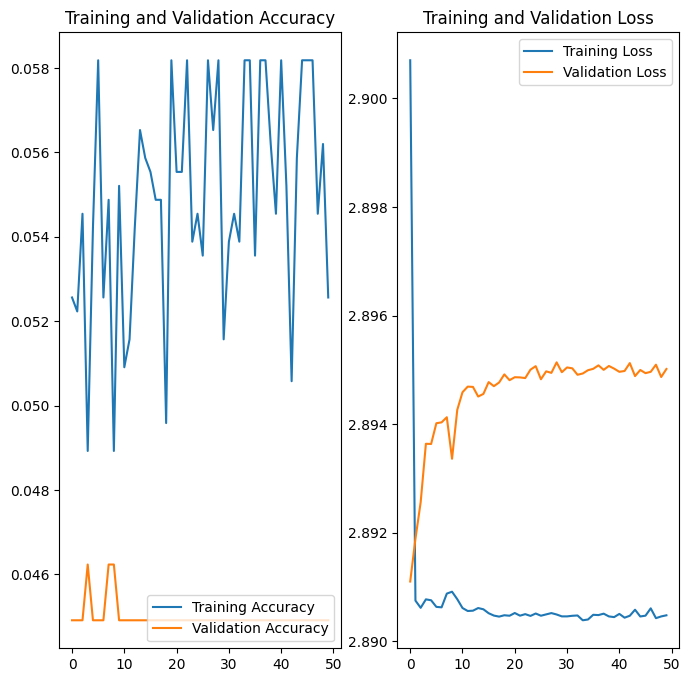

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# get image from local path
image = 'Ba.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

In [24]:
#make prediction
predictions = model.predict(img_bat)
#get score
score = tf.nn.softmax(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


In [25]:
print('Huruf ini termasuk kedalam {} dengan akurasi {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))

Huruf ini termasuk kedalam nga dengan akurasi 5.86


In [26]:
#image url
img_url = "https://upload.wikimedia.org/wikipedia/commons/0/0a/Sunda_Ba.png"
#dowload image
img_path = tf.keras.utils.get_file('Image_letter', origin=img_url)
#load image
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
# image to array
img_array = tf.keras.utils.array_to_img(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#make prediction
predictions = model.predict(img_array)
#get score
score = tf.nn.softmax(predictions[0])

print('Huruf ini termasuk kedalam {} dengan akurasi {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Huruf ini termasuk kedalam nga dengan akurasi 5.84


In [27]:
model.save('ImageClassification.keras')